### Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Loading the dataset

In [2]:
simulated_cleaned_tx_df = pd.read_csv('../SavedData/dataset2_cleaned.csv')

In [48]:
simulated_cleaned_tx_df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
0,01/01/2023,00:00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,2023-01-01 00:00:00
1,01/01/2023,00:00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,2023-01-01 00:00:00
2,01/01/2023,00:00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN,2023-01-01 00:00:00
3,01/01/2023,00:00:00,283027736.0,1787.000000,780.00,472213568.0,NaN,2023-01-01 00:00:00
4,01/01/2023,00:00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face,2023-01-01 00:00:00
...,...,...,...,...,...,...,...,...
229189,06/12/2023,20:54:00,581655972.0,45935.206861,-41.06,NaN,Tesco,2023-12-06 20:54:00
229190,06/12/2023,20:55:00,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,2023-12-06 20:55:00
229191,06/12/2023,21:05:00,824916823.0,9709.172159,-32.94,NaN,Deliveroo,2023-12-06 21:05:00
229192,06/12/2023,21:13:00,366550080.0,26834.165794,-19.25,NaN,Amazon,2023-12-06 21:13:00


### Splitting the data into training and testing 

In [3]:
copied_simulated_tx_df = simulated_cleaned_tx_df.copy()

# Splitting the copied dataset into historical_transactions and testing_transactions 
training_transactions, testing_transactions = train_test_split(copied_simulated_tx_df, test_size=0.2, random_state=12)

# Displaying the shapes to verify the split
training_transactions.shape, testing_transactions.shape


((183355, 8), (45839, 8))

In [33]:
testing_transactions.to_csv('../SavedData/dataset2_testing_transaction.csv', index=False)

In [35]:
training_transactions.to_csv('../SavedData/dataset2_training_transaction.csv',index=False)

### Splitting the training transactions into payments and expenditures

In [4]:
payments_training_df = training_transactions[training_transactions['Amount'] > 0]
expenditures_training_df = training_transactions[training_transactions['Amount'] < 0]

In [5]:
# Taking the absolute values of the amount column
expenditures_training_df["Amount"] = expenditures_training_df["Amount"].abs()

expenditures_training_df

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_2772/721076894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditures_training_df["Amount"] = expenditures_training_df["Amount"].abs()


,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
109964,25/06/2023,11:05:00,975345315.0,20105.404800,80.50,NaN,Topshop,2023-06-25 11:05:00
190427,17/10/2023,12:57:00,162370388.0,-2312.382900,43.42,NaN,Tesco,2023-10-17 12:57:00
81046,02/05/2023,19:18:00,145553416.0,-1516.558550,29.11,NaN,Tesco,2023-05-02 19:18:00
89182,22/05/2023,05:18:00,145387690.0,3671.032538,2.37,NaN,Sainsbury Local,2023-05-22 05:18:00
61119,31/03/2023,23:59:00,310171581.0,-651.334154,18.99,NaN,PureGym,2023-03-31 23:59:00
...,...,...,...,...,...,...,...,...
206083,05/11/2023,07:55:00,550169791.0,22875.430900,45.04,NaN,Etsy,2023-11-05 07:55:00
36482,23/02/2023,12:38:00,554792076.0,2248.810443,75.74,NaN,Topshop,2023-02-23 12:38:00
40177,01/03/2023,00:00:00,624563756.0,-14.727071,822.00,NaN,LBG,2023-03-01 00:00:00
150781,24/08/2023,20:15:00,176922958.0,1440.312330,37.43,NaN,Deliveroo,2023-08-24 20:15:00


## Creating an anomaly detection model using IQR for thresholds

### Threshold function

In [6]:
def calculate_thresholds(group, multiplier, percent_increment):
    quantiles = group['Amount'].quantile([0.25, 0.5, 0.75])
    IQR = quantiles[0.75] - quantiles[0.25]
    
    if IQR == 0:
        # When there's no variability, use the median and apply percent increment
        threshold = quantiles[0.5] * (1 + percent_increment)
    else:
        # Standard threshold calculation using IQR
        threshold = quantiles[0.75] + multiplier * IQR
    
    return threshold


### Creating anomaly detection dataframe: expenditures

In [7]:
# Ensure anomaly_detection_by_expenditures_df is indexed by 'Account No'
anomaly_detection_by_expenditures_df = expenditures_training_df[['Account No']].drop_duplicates().reset_index(drop=True)
anomaly_detection_by_expenditures_df.set_index('Account No', inplace=True)

# Assuming multipliers and percent_increments are defined as before
multipliers = [1.5, 3, 5]
percent_increments = [0.333, 0.666, 1]

# Define threshold columns
threshold_columns = ['Overall_Threshold_1_IQR', 'Overall_Threshold_2_IQR', 'Overall_Threshold_3_IQR']

# Initialising columns in anomaly_detection_by_expenditures_df to store threshold values
for col in threshold_columns:
    anomaly_detection_by_expenditures_df[col] = np.nan

# Calculate thresholds and update anomaly_detection_by_expenditures_df
for multiplier, percent_increment, col_name in zip(multipliers, percent_increments, threshold_columns):
    # Calculate thresholds for each Account No group
    thresholds = expenditures_training_df.groupby('Account No').apply(
        lambda group: calculate_thresholds(group, multiplier, percent_increment)
    ).reset_index(name=col_name)
    
    # Correctly index the thresholds DataFrame to facilitate direct mapping
    thresholds.set_index('Account No', inplace=True)
    
    # Map calculated thresholds to anomaly_detection_by_expenditures_df
    anomaly_detection_by_expenditures_df[col_name] = anomaly_detection_by_expenditures_df.index.map(
        thresholds[col_name]
    )

In [8]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_3']))).to_dict()

anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_1'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_2'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_3'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [9]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_3']))).to_dict()

anomaly_detection_by_expenditures_df['Business_Threshold_1'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_expenditures_df['Business_Threshold_2'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_expenditures_df['Business_Threshold_3'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [10]:
# Extracting keys from 'transfer_to_accounts_threshold_1_IQR' to create 'user_user_interaction'
anomaly_detection_by_expenditures_df['user_user_interaction'] = anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

# Extracting keys from 'industry_threshold_1_IQR' to create 'user_industry_interaction'
anomaly_detection_by_expenditures_df['user_business_interaction'] = anomaly_detection_by_expenditures_df['Business_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

anomaly_detection_by_expenditures_df


,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR,Third_Party_Account_Threshold_1,Third_Party_Account_Threshold_2,Third_Party_Account_Threshold_3,Business_Threshold_1,Business_Threshold_2,Business_Threshold_3,user_user_interaction,user_business_interaction
Account No,,,,,,,,,,,
975345315.0,190.38000,295.0200,434.5400,NaN,NaN,NaN,"{'Amazon': 23.39415, 'Blizzard': 19.98167, 'Bo...","{'Amazon': 29.255850000000002, 'Blizzard': 24....","{'Amazon': 35.1, 'Blizzard': 29.98, 'Boots': 1...",None,"[Amazon, Blizzard, Boots, Brilliant Brushes, C..."
162370388.0,325.70875,511.5400,759.3150,{574137161.0: 559.86},{574137161.0: 700.14},{574137161.0: 840.0},"{'Amazon': 10.65067, 'Fat Face': 151.962, 'LBG...","{'Amazon': 13.31933, 'Fat Face': 190.038, 'LBG...","{'Amazon': 15.98, 'Fat Face': 228.0, 'LBG': 25...",[574137161.0],"[Amazon, Fat Face, LBG, Loosely Fitted, Matala..."
145553416.0,89.40250,133.4500,192.1800,NaN,NaN,NaN,"{'Blizzard': 19.98167, 'Deliveroo': 36.4049999...","{'Blizzard': 24.98833, 'Deliveroo': 36.8924999...","{'Blizzard': 29.98, 'Deliveroo': 37.5424999999...",None,"[Blizzard, Deliveroo, Fat Face, JustEat, Mojan..."
145387690.0,101.70000,154.3350,224.5150,NaN,NaN,NaN,"{'AMAZON': 48.824999999999996, 'Amazon': 65.02...","{'AMAZON': 75.0, 'Amazon': 100.1, 'Blackwell's...","{'AMAZON': 109.9, 'Amazon': 146.87, 'Blackwell...",None,"[AMAZON, Amazon, Blackwell's, Blizzard, Boots,..."
310171581.0,84.62250,126.2775,181.8175,NaN,NaN,NaN,"{'Blizzard': 19.98167, 'Deliveroo': 33.25835, ...","{'Blizzard': 24.98833, 'Deliveroo': 41.59165, ...","{'Blizzard': 29.98, 'Deliveroo': 49.9, 'Etsy':...",None,"[Blizzard, Deliveroo, Etsy, Gamestation, JustE..."
...,...,...,...,...,...,...,...,...,...,...,...
331684336.0,1898.95500,3017.9100,4509.8500,{250957494.0: 1039.74},{250957494.0: 1300.26},{250957494.0: 1560.0},"{'Blackwell's': 33.83749999999999, 'Deliveroo'...","{'Blackwell's': 41.70499999999999, 'Deliveroo'...","{'Blackwell's': 52.194999999999986, 'Deliveroo...",[250957494.0],"[Blackwell's, Deliveroo, Halifax, JustEat, Sai..."
744211756.0,90.68375,137.3000,199.4550,NaN,NaN,NaN,"{'Amazon': 10.65067, 'Blizzard': 19.98167, 'Br...","{'Amazon': 13.31933, 'Blizzard': 24.98833, 'Br...","{'Amazon': 15.98, 'Blizzard': 29.98, 'Brillian...",None,"[Amazon, Blizzard, Brilliant Brushes, CeX, Del..."
426466211.0,236.88500,369.5450,546.4250,{311467864.0: 546.53},{311467864.0: 683.47},{311467864.0: 820.0},"{'Blackwell's': 39.93668, 'Blizzard': 19.98167...","{'Blackwell's': 49.94332, 'Blizzard': 24.98833...","{'Blackwell's': 59.92, 'Blizzard': 29.98, 'CeX...",[311467864.0],"[Blackwell's, Blizzard, CeX, Deliveroo, Gamest..."


### Creating anomaly detection dataframe: payments

In [11]:
# Ensure anomaly_detection_by_expenditures_df is indexed by 'Account No'
anomaly_detection_by_payments_df = payments_training_df[['Account No']].drop_duplicates().reset_index(drop=True)
anomaly_detection_by_payments_df.set_index('Account No', inplace=True)

# Assuming multipliers and percent_increments are defined as before
multipliers = [1.5, 3, 5]
percent_increments = [0.333, 0.666, 1]

# Define threshold columns
threshold_columns = ['Overall_Threshold_1_IQR', 'Overall_Threshold_2_IQR', 'Overall_Threshold_3_IQR']

# Initializing columns in anomaly_detection_by_expenditures_df to store threshold values
for col in threshold_columns:
    anomaly_detection_by_payments_df[col] = np.nan

# Calculate thresholds and update anomaly_detection_by_expenditures_df
for multiplier, percent_increment, col_name in zip(multipliers, percent_increments, threshold_columns):
    # Calculate thresholds for each Account No group
    thresholds = payments_training_df.groupby('Account No').apply(
        lambda group: calculate_thresholds(group, multiplier, percent_increment)
    ).reset_index(name=col_name)
    
    # Correctly index the thresholds DataFrame to facilitate direct mapping
    thresholds.set_index('Account No', inplace=True)
    
    # Map calculated thresholds to anomaly_detection_by_expenditures_df
    anomaly_detection_by_payments_df[col_name] = anomaly_detection_by_payments_df.index.map(
        thresholds[col_name]
    )
anomaly_detection_by_payments_df

,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR
Account No,,,
179173981.0,2432.725,3040.450,3650.0
624563756.0,2427.393,3033.786,3642.0
354894456.0,2258.102,2822.204,3388.0
815993333.0,1532.950,1915.900,2300.0
587225252.0,3800.000,5600.000,8000.0
...,...,...,...
198630866.0,1070.000,1475.000,2015.0
656389634.0,4585.520,5731.040,6880.0
715068825.0,3500.000,4250.000,5250.0


In [12]:
thresholds_1 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_3']))).to_dict()

anomaly_detection_by_payments_df['Third_Party_Account_Threshold_1'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_payments_df['Third_Party_Account_Threshold_2'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_payments_df['Third_Party_Account_Threshold_3'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [13]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_3']))).to_dict()

anomaly_detection_by_payments_df['Business_Threshold_1'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_payments_df['Business_Threshold_2'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_payments_df['Business_Threshold_3'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))


In [14]:
# Extracting keys from 'transfer_to_accounts_threshold_1_IQR' to create 'user_user_interaction'
anomaly_detection_by_payments_df['user_user_interaction'] = anomaly_detection_by_payments_df['Third_Party_Account_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

# Extracting keys from 'industry_threshold_1_IQR' to create 'user_industry_interaction'
anomaly_detection_by_payments_df['user_business_interaction'] = anomaly_detection_by_payments_df['Business_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)


In [15]:
anomaly_detection_by_payments_df

,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR,Third_Party_Account_Threshold_1,Third_Party_Account_Threshold_2,Third_Party_Account_Threshold_3,Business_Threshold_1,Business_Threshold_2,Business_Threshold_3,user_user_interaction,user_business_interaction
Account No,,,,,,,,,,,
179173981.0,2432.725,3040.450,3650.0,NaN,NaN,NaN,{'Matalan': 2432.725},{'Matalan': 3042.275},{'Matalan': 3650.0},None,[Matalan]
624563756.0,2427.393,3033.786,3642.0,NaN,NaN,NaN,{'CPA': 2427.393},{'CPA': 3035.607},{'CPA': 3642.0},None,[CPA]
354894456.0,2258.102,2822.204,3388.0,NaN,NaN,NaN,{'Happy Days Home': 2258.102},{'Happy Days Home': 2823.898},{'Happy Days Home': 3388.0},None,[Happy Days Home]
815993333.0,1532.950,1915.900,2300.0,{992204045.0: 1532.95},{992204045.0: 1917.05},{992204045.0: 2300.0},NaN,NaN,NaN,[992204045.0],None
587225252.0,3800.000,5600.000,8000.0,{425964226.0: 1066.3999999999999},{425964226.0: 1333.6000000000001},{425964226.0: 1600.0},{'Matalan': 2666.0},{'Matalan': 3334.0},{'Matalan': 4000.0},[425964226.0],[Matalan]
...,...,...,...,...,...,...,...,...,...,...,...
198630866.0,1070.000,1475.000,2015.0,{919185264.0: 1070.0},{919185264.0: 1475.0},{919185264.0: 2015.0},NaN,NaN,NaN,[919185264.0],None
656389634.0,4585.520,5731.040,6880.0,{449871732.0: 4585.5199999999995},{449871732.0: 5734.4800000000005},{449871732.0: 6880.0},NaN,NaN,NaN,[449871732.0],None
715068825.0,3500.000,4250.000,5250.0,{199016328.0: 3500.0},{199016328.0: 4250.0},{199016328.0: 5250.0},NaN,NaN,NaN,[199016328.0],None


## Risk flagging function- per user transaction

In [16]:
def get_threshold_value(user_data, key, identifier=None):
    """
    Retrieves threshold values for different risk levels from the user's data.
    If the threshold value for a specific key is a dictionary, it returns the threshold
    for the specified identifier. If no identifier-specific threshold is found,
    it returns a high default threshold.
    """
    value = user_data.get(key, 0)
    return value if not isinstance(value, dict) else value.get(identifier, float('inf'))

def assess_transaction_risk(account_no, amount, third_party_account_no, third_party_name, anomaly_detection_by_expenditures_df, anomaly_detection_by_payments_df):
    if amount >= 0:
        anomaly_detection_df = anomaly_detection_by_payments_df
    else:
        anomaly_detection_df = anomaly_detection_by_expenditures_df

    amount = abs(amount)  # Convert amount to absolute for uniform comparison
    # Safely fetch user data; default to an empty dict if the account_no is not found
    user_data = anomaly_detection_df.loc[account_no].to_dict() if account_no in anomaly_detection_df.index else {}

    # Initialize interaction lists safely
    user_user_interaction = user_data.get('user_user_interaction', []) or []
    user_business_interaction = user_data.get('user_business_interaction', []) or []

    risk_level = "No Risk"

    # Check for third-party account interactions
    if third_party_account_no and third_party_account_no in user_user_interaction:
        thresholds = [
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_1', third_party_account_no),
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_2', third_party_account_no),
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_3', third_party_account_no)
        ]
    # Check for business interactions
    elif third_party_name and third_party_name in user_business_interaction:
        thresholds = [
            get_threshold_value(user_data, 'Business_Threshold_1', third_party_name),
            get_threshold_value(user_data, 'Business_Threshold_2', third_party_name),
            get_threshold_value(user_data, 'Business_Threshold_3', third_party_name)
        ]
    else:
        # Default to overall thresholds if specific ones aren't found or applicable
        thresholds = [
            user_data.get('Overall_Threshold_1_IQR', float('inf')),
            user_data.get('Overall_Threshold_2_IQR', float('inf')),
            user_data.get('Overall_Threshold_3_IQR', float('inf'))
        ]
    # Determine the risk level based on thresholds
    if amount > thresholds[2]:
        risk_level = "High Risk"
    elif amount > thresholds[1]:
        risk_level = "Medium Risk"
    elif amount > thresholds[0]:
        risk_level = "Low Risk"

    # Adjust the risk level based on absolute amount thresholds
    if amount <= 15:
        risk_level = "No Risk"
    elif amount <= 50:
        risk_level = "Low Risk" if risk_level != "No Risk" else "No Risk"
    elif amount <= 100:
        risk_level = "Medium Risk" if risk_level == "High Risk" else risk_level

    return risk_level


In [17]:
testing_transactions['risk_level'] = [
    assess_transaction_risk(
        row['Account No'], row['Amount'], row.get('Third Party Account No'), row.get('Third Party Name'),
        anomaly_detection_by_expenditures_df, anomaly_detection_by_payments_df
    ) for _, row in testing_transactions.iterrows()
]


testing_transactions.shape

(45839, 9)

In [18]:
risk_level_counts = testing_transactions['risk_level'].value_counts()
print(risk_level_counts)


No Risk        43727
Low Risk        1445
Medium Risk      449
High Risk        218
Name: risk_level, dtype: int64


In [49]:
# Filter for Low Risk transactions

no_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'No Risk']

low_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'Low Risk']

# Filter for Medium Risk transactions
medium_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'Medium Risk']

# Filter for High Risk transactions
high_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'High Risk']


In [55]:
# Assuming testing_transactions is your DataFrame and it's already defined
# Define the mapping dictionary
risk_level_map = {
    'No Risk': 0,
    'Low Risk': 0.33,
    'Medium Risk': 0.66,
    'High Risk': 1
}


testing_transactions['risk_level_numeric'] = testing_transactions['risk_level'].map(risk_level_map)

testing_transactions[testing_transactions['risk_level_numeric']== 0.33]

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
141449,06/08/2023,03:33:00,496395938.0,11089.827658,-88.40,NaN,Loosely Fitted,2023-08-06 03:33:00,Low Risk,0.33
128615,22/07/2023,11:02:00,147474476.0,3781.733037,-105.73,NaN,Revella,2023-07-22 11:02:00,Low Risk,0.33
175960,30/09/2023,10:48:00,930277104.0,11141.312949,-235.20,NaN,Fat Face,2023-09-30 10:48:00,Low Risk,0.33
145302,13/08/2023,12:17:00,541639148.0,4904.981751,-130.89,NaN,Fat Face,2023-08-13 12:17:00,Low Risk,0.33
124005,12/07/2023,06:01:00,128033695.0,4233.570223,-25.98,NaN,Sainsbury Local,2023-07-12 06:01:00,Low Risk,0.33
...,...,...,...,...,...,...,...,...,...,...
48634,10/03/2023,17:14:00,657528784.0,-689.588100,-312.20,NaN,Loosely Fitted,2023-03-10 17:14:00,Low Risk,0.33
84134,09/05/2023,16:18:00,478412511.0,1379.999324,-34.95,NaN,The Works,2023-05-09 16:18:00,Low Risk,0.33
19526,29/01/2023,13:21:00,285115279.0,-28.160330,-152.60,NaN,Topshop,2023-01-29 13:21:00,Low Risk,0.33
184191,06/10/2023,05:17:00,187111705.0,6865.321633,-38.92,NaN,Amazon,2023-10-06 05:17:00,Low Risk,0.33


In [20]:
low_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level
141449,06/08/2023,03:33:00,496395938.0,11089.827658,-88.40,NaN,Loosely Fitted,2023-08-06 03:33:00,Low Risk
128615,22/07/2023,11:02:00,147474476.0,3781.733037,-105.73,NaN,Revella,2023-07-22 11:02:00,Low Risk
175960,30/09/2023,10:48:00,930277104.0,11141.312949,-235.20,NaN,Fat Face,2023-09-30 10:48:00,Low Risk
145302,13/08/2023,12:17:00,541639148.0,4904.981751,-130.89,NaN,Fat Face,2023-08-13 12:17:00,Low Risk
124005,12/07/2023,06:01:00,128033695.0,4233.570223,-25.98,NaN,Sainsbury Local,2023-07-12 06:01:00,Low Risk
...,...,...,...,...,...,...,...,...,...
48634,10/03/2023,17:14:00,657528784.0,-689.588100,-312.20,NaN,Loosely Fitted,2023-03-10 17:14:00,Low Risk
84134,09/05/2023,16:18:00,478412511.0,1379.999324,-34.95,NaN,The Works,2023-05-09 16:18:00,Low Risk
19526,29/01/2023,13:21:00,285115279.0,-28.160330,-152.60,NaN,Topshop,2023-01-29 13:21:00,Low Risk
184191,06/10/2023,05:17:00,187111705.0,6865.321633,-38.92,NaN,Amazon,2023-10-06 05:17:00,Low Risk


In [21]:
medium_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level
14645,18/01/2023,17:22:00,643610517.0,-219.303691,-136.49,NaN,Fat Face,2023-01-18 17:22:00,Medium Risk
106536,17/06/2023,13:29:00,303843160.0,968.263000,-208.60,NaN,Topshop,2023-06-17 13:29:00,Medium Risk
186321,09/10/2023,18:10:00,897592348.0,14606.655986,-221.20,NaN,Matalan,2023-10-09 18:10:00,Medium Risk
72788,26/04/2023,18:43:00,901432314.0,2628.057097,-99.97,NaN,Hobby Lobby,2023-04-26 18:43:00,Medium Risk
176306,30/09/2023,18:26:00,316793091.0,1641.014310,-51.49,NaN,Hobby Lobby,2023-09-30 18:26:00,Medium Risk
...,...,...,...,...,...,...,...,...,...
64103,04/04/2023,17:57:00,291580432.0,79.391500,-143.99,NaN,Topshop,2023-04-04 17:57:00,Medium Risk
14156,17/01/2023,13:48:00,532525712.0,350.958700,-79.98,NaN,Gamestation,2023-01-17 13:48:00,Medium Risk
11869,13/01/2023,09:45:00,158766229.0,1587.929551,-86.97,NaN,Brilliant Brushes,2023-01-13 09:45:00,Medium Risk
7703,05/01/2023,12:39:00,895331556.0,675.130000,-99.98,NaN,Gamestation,2023-01-05 12:39:00,Medium Risk


In [22]:
high_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level
107134,18/06/2023,16:11:00,383345285.0,363.732176,-112.98,NaN,Sports Direct,2023-06-18 16:11:00,High Risk
98684,01/06/2023,10:20:00,627936697.0,1140.717600,-193.50,NaN,Topshop,2023-06-01 10:20:00,High Risk
17541,24/01/2023,19:54:00,994214354.0,980.830000,-1870.00,534204159.0,NaN,2023-01-24 19:54:00,High Risk
33711,16/02/2023,09:31:00,950234174.0,815.028676,-150.12,NaN,Gamestation,2023-02-16 09:31:00,High Risk
28469,04/02/2023,17:11:00,478651121.0,648.543830,-197.00,NaN,Matalan,2023-02-04 17:11:00,High Risk
...,...,...,...,...,...,...,...,...,...
188949,14/10/2023,17:56:00,373875019.0,15831.854013,-258.30,NaN,Fitted Stitch,2023-10-14 17:56:00,High Risk
144233,11/08/2023,14:04:00,601627384.0,4720.955092,-187.01,NaN,JD Sports,2023-08-11 14:04:00,High Risk
211303,14/11/2023,10:53:00,652048867.0,-1.449100,-500.00,512989907.0,NaN,2023-11-14 10:53:00,High Risk
182093,02/10/2023,10:08:00,391688371.0,496.282300,-1470.00,534097839.0,NaN,2023-10-02 10:08:00,High Risk


In [23]:
account = anomaly_detection_by_payments_df[anomaly_detection_by_payments_df.index == 994214354.0]
account


,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR,Third_Party_Account_Threshold_1,Third_Party_Account_Threshold_2,Third_Party_Account_Threshold_3,Business_Threshold_1,Business_Threshold_2,Business_Threshold_3,user_user_interaction,user_business_interaction
Account No,,,,,,,,,,,
994214354.0,3997.667,4996.334,5998.0,NaN,NaN,NaN,{'Fitted Stitch': 3997.667},{'Fitted Stitch': 4999.3330000000005},{'Fitted Stitch': 5998.0},None,[Fitted Stitch]


In [24]:
account = anomaly_detection_by_expenditures_df.loc[524425303.0, 'Business_Threshold_3']
account

{'Amazon': 15.98,
 "Blackwell's": 93.36500000000001,
 'Blizzard': 29.98,
 'CeX': 389.91999999999996,
 'Deliveroo': 24.787499999999998,
 'Fat Face': 599.0,
 'Five Senses Art': 317.37,
 'Grand Union BJJ': 200.0,
 'JustEat': 45.59,
 'LBG': 1834.0,
 'Matalan': 275.0,
 'Mojang Studios': 11.98,
 'Netflix': 31.98,
 'PureGym': 37.98,
 'Revella': 1052.5,
 'Sports Direct': 394.5849999999999,
 'Starbucks': 10.0,
 'Tesco': 259.98749999999995,
 'Wool': 26.049999999999997,
 'Xbox': 14.0}

### Plotting results

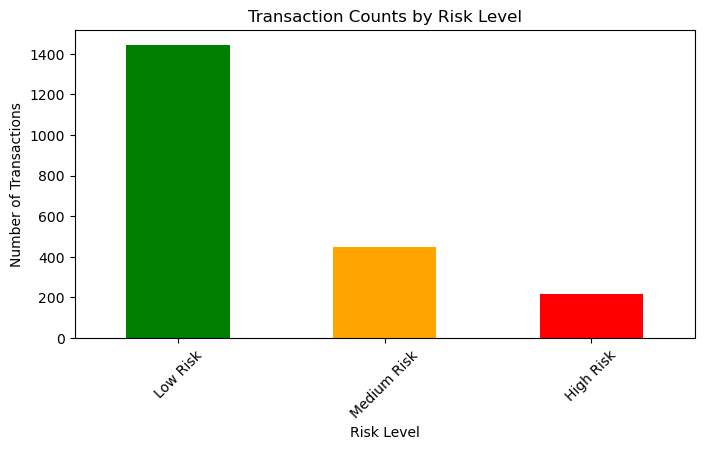

In [25]:
risk_level_counts = pd.Series({
    "Low Risk": low_risk_transactions.shape[0],
    "Medium Risk": medium_risk_transactions.shape[0],  
    "High Risk": high_risk_transactions.shape[0],    
})

# Plotting
risk_level_counts.plot(kind='bar', figsize=(8, 4), color=['green', 'orange', 'red', 'blue'])
plt.title('Transaction Counts by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

This is out of the testing set of 45839.

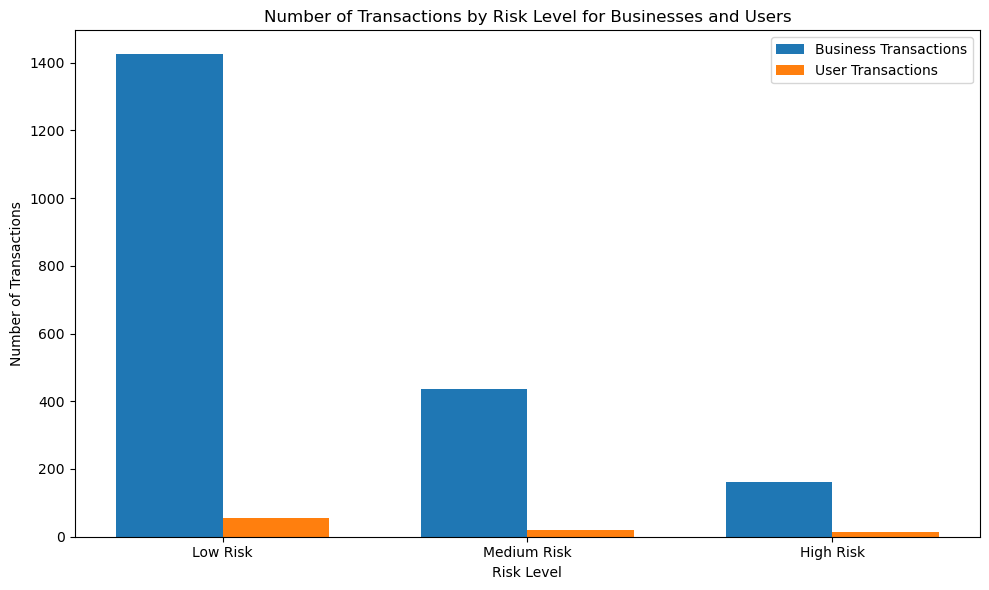

In [26]:
# Combine all transactions into a single DataFrame with an additional 'risk_level' column
all_transactions = pd.concat([
    low_risk_transactions.assign(risk_level='Low Risk'),
    medium_risk_transactions.assign(risk_level='Medium Risk'),
    high_risk_transactions.assign(risk_level='High Risk')
])

# Filter transactions by business and user
business_transactions = all_transactions[all_transactions['Third Party Name'].notnull()]
user_transactions = all_transactions[all_transactions['Third Party Account No'].notnull()]

# Count the number of transactions by risk level
business_risk_counts = business_transactions['risk_level'].value_counts()
user_risk_counts = user_transactions['risk_level'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(business_risk_counts))

plt.bar(index, business_risk_counts, bar_width, label='Business Transactions')
plt.bar(index + bar_width, user_risk_counts, bar_width, label='User Transactions')

plt.xlabel('Risk Level')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Risk Level for Businesses and Users')
plt.xticks(index + bar_width / 2, business_risk_counts.index)
plt.legend()

plt.tight_layout()
plt.show()


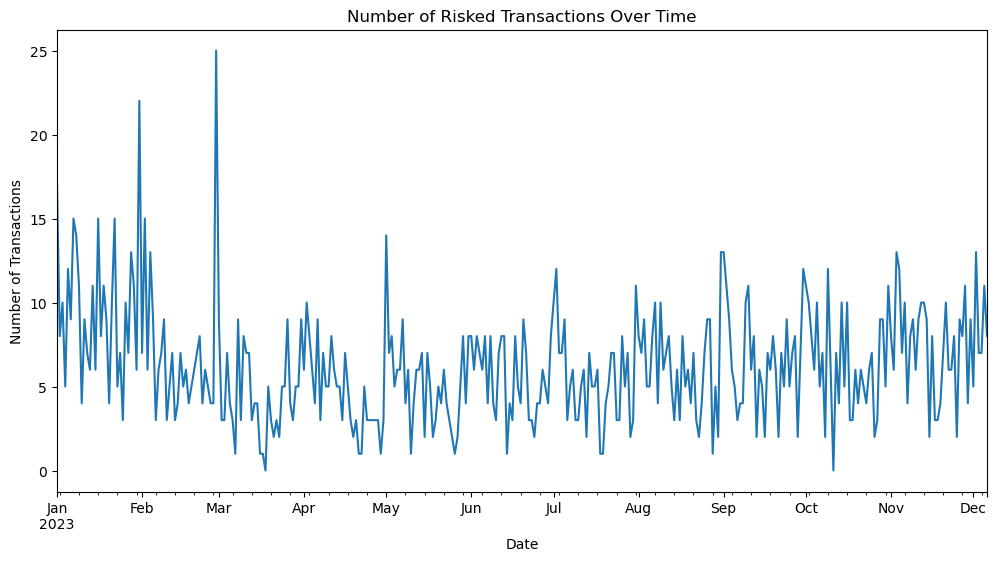

In [27]:
# Convert 'Datetime' to datetime and set as index
all_transactions['Datetime'] = pd.to_datetime(all_transactions['Datetime'])
all_transactions.set_index('Datetime', inplace=True)

# Resample by day and count transactions
daily_transactions = all_transactions.resample('D').size()

plt.figure(figsize=(12, 6))
daily_transactions.plot(title='Number of Risked Transactions Over Time')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
plt.show()


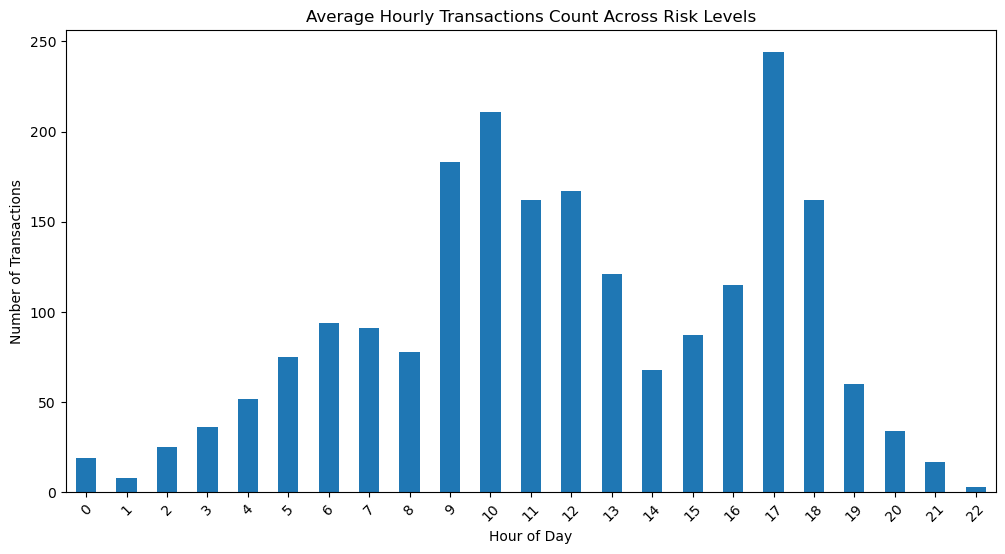

In [28]:
# Extract hour from the index and count transactions per hour
hourly_transactions = all_transactions.groupby(all_transactions.index.hour).size()

plt.figure(figsize=(12, 6))
hourly_transactions.plot(kind='bar', title='Average Hourly Transactions Count Across Risk Levels')
plt.ylabel('Number of Transactions')
plt.xlabel('Hour of Day')
plt.xticks(rotation=45)
plt.show()


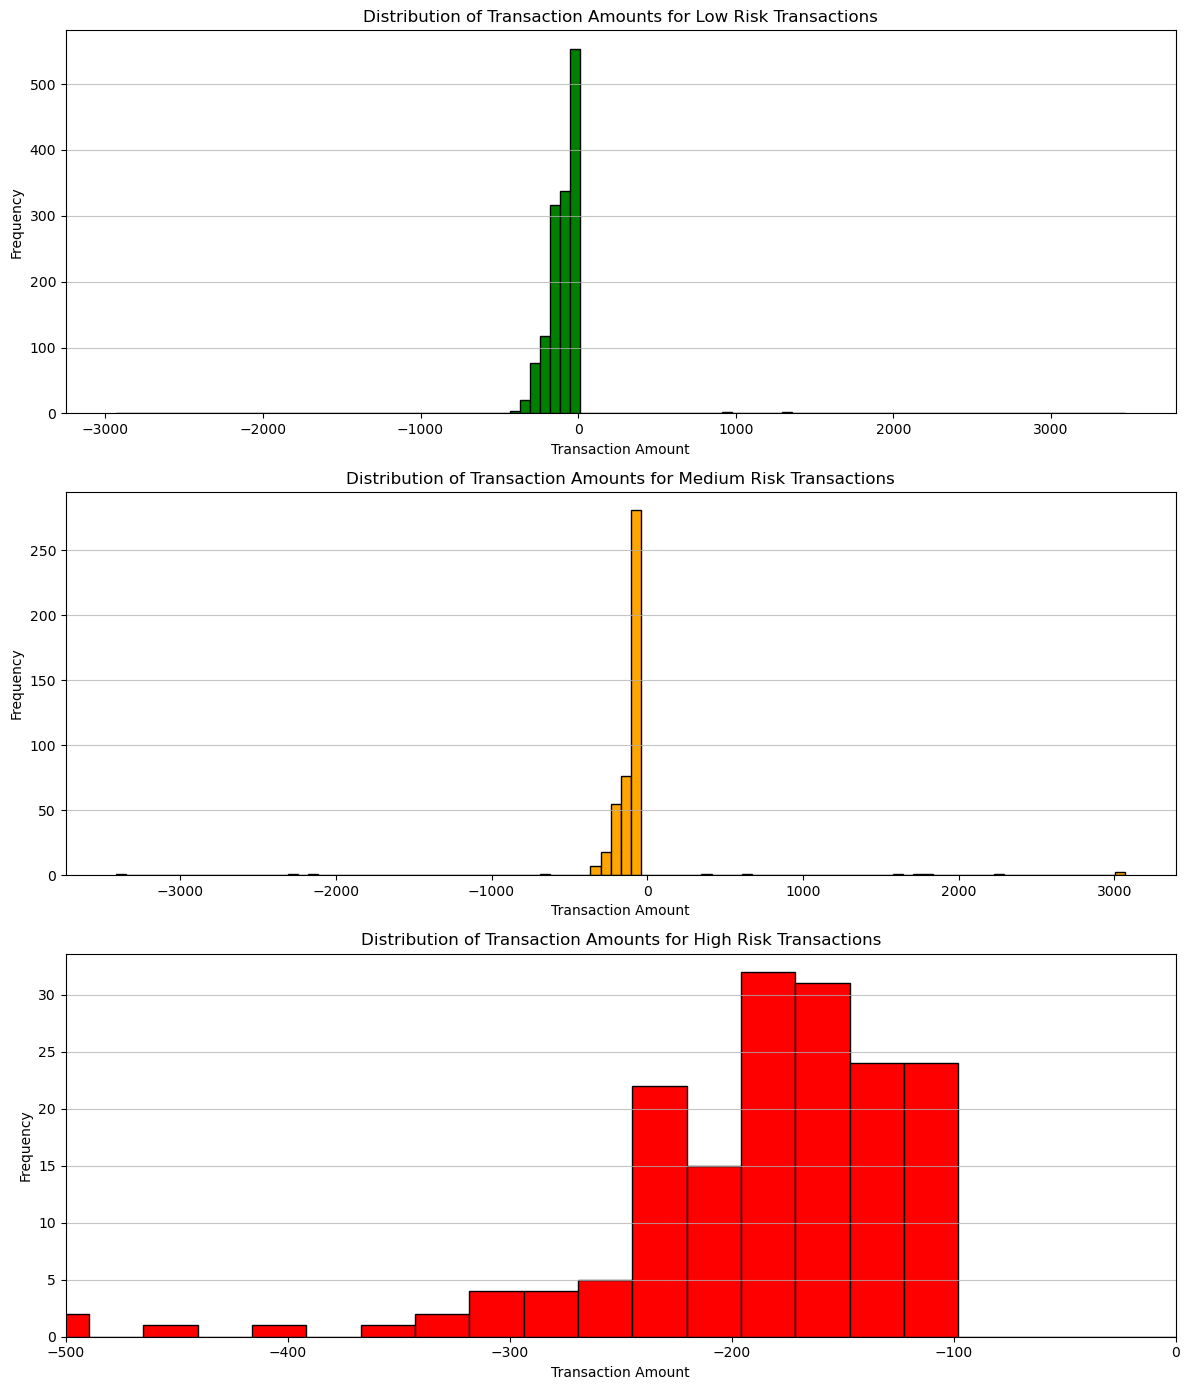

In [46]:


fig, axs = plt.subplots(3, 1, figsize=(12, 14))  # Share the x-axis

# Histogram for Transaction Amounts for Low Risk Transactions
axs[0].hist(low_risk_transactions['Amount'], bins=100, color='green', edgecolor='black')
axs[0].set_title('Distribution of Transaction Amounts for Low Risk Transactions')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Transaction Amount')
axs[0].grid(axis='y', alpha=0.75)

# Histogram for Transaction Amounts for Medium Risk Transactions
axs[1].hist(medium_risk_transactions['Amount'], bins=100, color='orange', edgecolor='black')
axs[1].set_title('Distribution of Transaction Amounts for Medium Risk Transactions')
axs[1].set_xlabel('Transaction Amount')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y', alpha=0.75)

# Histogram for Transaction Amounts for High Risk Transactions
axs[2].hist(high_risk_transactions['Amount'], bins=1000, color='red', edgecolor='black')
axs[2].set_title('Distribution of Transaction Amounts for High Risk Transactions')
axs[2].set_xlabel('Transaction Amount')
axs[2].set_xlim(-500, 0)
axs[2].set_ylabel('Frequency')
axs[2].grid(axis='y', alpha=0.75)

# Adjust layout
plt.tight_layout()
plt.show()



In [58]:
import datetime
given_date = expenditures_training_df['Datetime'][0]
formated_date = datetime.datetime.strptime(given_date,"%m/%d/%Y, %H:%M:%S")
Unix_timestamp = datetime.datetime.timestamp(formated_date)
print("The Unix timestamp for the given input date is:")
print(Unix_timestamp)

KeyError: 0

In [94]:
def unix_ts_convert(date):
    given_date = date
    formated_date = datetime.datetime.strptime(given_date,"%Y-%m-%d %H:%M:%S")
    Unix_timestamp = datetime.datetime.timestamp(formated_date)
    return int(Unix_timestamp)

In [100]:
iso_forest_tx = simulated_cleaned_tx_df.reset_index()
iso_forest_tx['Unix Timestamp'] = iso_forest_tx['Datetime'].apply(unix_ts_convert)

In [128]:
Account_Nos = list(iso_forest_tx['Account No'].unique())

In [130]:
Account_Nos

[678330503.0,
 472213568.0,
 283027736.0,
 624500124.0,
 203466392.0,
 768271776.0,
 215404070.0,
 456221621.0,
 350921975.0,
 455831435.0,
 442079728.0,
 832564361.0,
 407574996.0,
 172084472.0,
 442070890.0,
 605711527.0,
 744968736.0,
 865748375.0,
 548907062.0,
 522188082.0,
 786141370.0,
 616924659.0,
 979135922.0,
 370757362.0,
 399144202.0,
 637433131.0,
 754141345.0,
 412823730.0,
 119993184.0,
 384497904.0,
 298000165.0,
 241459011.0,
 604288474.0,
 720742759.0,
 200080192.0,
 183888402.0,
 532478725.0,
 680773155.0,
 215426302.0,
 285428103.0,
 925037906.0,
 892354433.0,
 820686957.0,
 744398361.0,
 145387690.0,
 414805878.0,
 776431321.0,
 666952234.0,
 345582855.0,
 308068836.0,
 722971557.0,
 183546640.0,
 143606916.0,
 705848712.0,
 214339619.0,
 565175333.0,
 168414279.0,
 435313070.0,
 426466211.0,
 311467864.0,
 913801979.0,
 108481285.0,
 994214354.0,
 475277431.0,
 454356905.0,
 660874296.0,
 280098744.0,
 889916166.0,
 783650950.0,
 868377987.0,
 828750680.0,
 17063

In [112]:
iso_forest_user_groups = iso_forest_tx.groupby('Account No')

In [118]:
iso_forest_user_groups.apply(lambda x: x)

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_2772/3860438644.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  iso_forest_user_groups.apply(lambda x: x)


,index,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,Unix Timestamp
0,0,01/01/2023,00:00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,2023-01-01 00:00:00,1672531200
1,1,01/01/2023,00:00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,2023-01-01 00:00:00,1672531200
2,2,01/01/2023,00:00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN,2023-01-01 00:00:00,1672531200
3,3,01/01/2023,00:00:00,283027736.0,1787.000000,780.00,472213568.0,NaN,2023-01-01 00:00:00,1672531200
4,4,01/01/2023,00:00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face,2023-01-01 00:00:00,1672531200
...,...,...,...,...,...,...,...,...,...,...
229189,229189,06/12/2023,20:54:00,581655972.0,45935.206861,-41.06,NaN,Tesco,2023-12-06 20:54:00,1701896040
229190,229190,06/12/2023,20:55:00,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,2023-12-06 20:55:00,1701896100
229191,229191,06/12/2023,21:05:00,824916823.0,9709.172159,-32.94,NaN,Deliveroo,2023-12-06 21:05:00,1701896700
229192,229192,06/12/2023,21:13:00,366550080.0,26834.165794,-19.25,NaN,Amazon,2023-12-06 21:13:00,1701897180


In [99]:
given_date['Datetime']

biz_tx_count = biz_tx_df.groupby('to_randomly_generated_account')['monopoly_money_amount'].count()

0        2023-03-14 18:33:00
1        2023-03-14 17:28:00
2        2023-08-31 23:59:00
3        2023-10-31 09:27:00
4        2023-03-05 16:34:00
                ...         
45834    2023-07-31 23:59:00
45835    2023-02-02 14:46:00
45836    2023-01-11 19:39:00
45837    2023-05-31 23:59:00
45838    2023-09-30 00:00:00
Name: Datetime, Length: 45839, dtype: object